# ***NASA - Nearest Earth Object Classification***
### Code written by [__*Irmak Aslan*__](mailto:aslan.irmak@metu.edu.tr).
### Data Source: [Kaggle](https://www.kaggle.com/code/alyssasoderlund/eda-and-model-building/data)
### Notebook Link: [Kaggle](https://www.kaggle.com/code/aslanirmak/nearest-earth-objects)

### Dataset Description:
This dataset contains information about asteroids orbiting earth. It is important to understand objects close to earth, as they can impact the earth in many ways and distrupt the earths natural phenomena. Information about the size, velocity, distance from earths orbit, and the magnitude of the luminosity of the asteroid can help experts identify whether an asteroid poses a threat or not. This project will analyze information about these asteroids, and attempt to create a model to predict whether or not an asteroid is potentially hazardous.

The attributes of this dataset are:

- id : identifier (the same object can have several rows in the dataset, as it has been observed multiple times)
- name : name given by NASA (including the year the asteroid was discovered)
- est_diameter_min : minimum estimated diameter in kilometers
- est_diameter_max : maximum estimated diameter in kilometers
- relative_velocity : velocity relative to earth
- miss_distance : distance in kilometers it misses Earth
- orbiting_body : planet that the asteroid orbits
- sentry_object : whether it is included in sentry - an automated collision monitoring system
- absolute_magnitude : intrinsic luminosity
- hazardous : whether the asteriod is potentially harmful or not

This dataset has 10 columns and 90,836 rows. It has no missing values.


## 1- Data Understanding and Preperation

In this section, we are going to import, and prepare our data.

It is especially important to see that we can extract the year an astreoid is discovered by applying some functions to 'name' column. Even though we are able to collect most of the discovery years by only manipulating the strings, for some instances we have to use a control block to fix some unwanted values returned to us.

In [60]:
# Import required modules.
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report, confusion_matrix, RocCurveDisplay
from imblearn.over_sampling import SMOTE

# Set theme for seaborn plots.
sns.set_theme(style="whitegrid")

In [9]:
# Import and prepare dataset.
path = "neo_v2.csv"
df = pd.read_csv(path)

# Taking a look at what out data looks like.
df.head(3)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False


In [10]:
# Get detected years of astreoids from names of the astreoids.
def get_year(name):
    # Years are usually in parantheses, but for some specific values, we need a control block.
    year = name[name.index("(") + 1: name.index(")")][0:4]
    if year == "A/20":
        year = 2019
    elif year == "A924":
        year = 1924
    elif year == "A911":
        year = 1911
    elif year == "A898":
        year = 1898
    elif year == "4788":
        year = 1998
    elif year == "6344":
        year = 1960
    elif year == "6743":
        year = 1960

    return year
    
years = df.name.apply(get_year).astype(int)

# Change name column to year column.
df["name"] = years
df.rename(columns={"name": "year"}, inplace=True)
df.head(3)

,id,year,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,2000,1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,2005,0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,2015,0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False


## 2- Data Exploration by Visualization
Now, Our data is ready to be explored. We will try to detect relationships between features and target variable hazardous.

We need to detect overlappings and discreteneses to understand if the feature is linked to target variable somehow. Kernel Density Estimate(KDE) Plots and Boxplots are suited for this purpose.

<AxesSubplot:xlabel='year', ylabel='hazardous'>

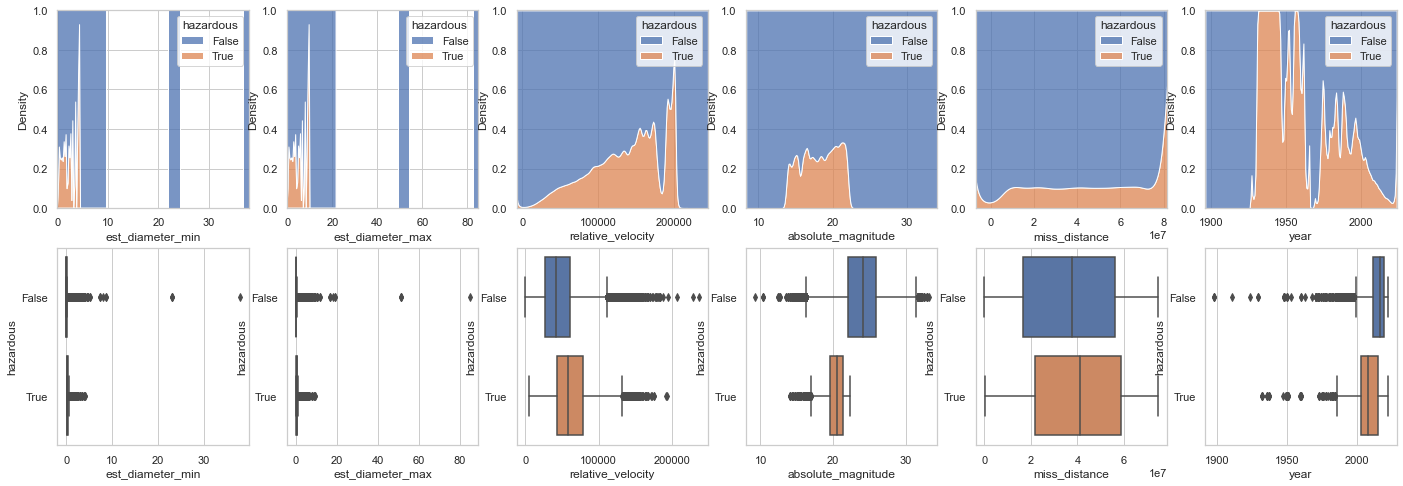

In [11]:
# Plot figures to detect relationships between features and target variable 'hazardous'.
fig, axs = plt.subplots(ncols=6, nrows=2)
fig.set_size_inches((24, 8))

sns.kdeplot(x="est_diameter_min", hue="hazardous", data=df, multiple="fill", ax=axs[0][0])
sns.kdeplot(x="est_diameter_max", hue="hazardous", data=df, multiple="fill", ax=axs[0][1])
sns.kdeplot(x="relative_velocity", hue="hazardous", data=df, multiple="fill", ax=axs[0][2])
sns.kdeplot(x="absolute_magnitude", hue="hazardous", data=df, multiple="fill", ax=axs[0][3])
sns.kdeplot(x="miss_distance", hue="hazardous", data=df, multiple="fill", ax=axs[0][4])
sns.kdeplot(x="year", hue="hazardous", data=df, multiple="fill", ax=axs[0][5])

sns.boxplot(x="est_diameter_min", y="hazardous", data=df, orient="h", ax=axs[1][0])
sns.boxplot(x="est_diameter_max", y="hazardous", data=df, orient="h", ax=axs[1][1])
sns.boxplot(x="relative_velocity", y="hazardous", data=df, orient="h", ax=axs[1][2])
sns.boxplot(x="absolute_magnitude", y="hazardous", data=df, orient="h", ax=axs[1][3])
sns.boxplot(x="miss_distance", y="hazardous", data=df, orient="h", ax=axs[1][4])
sns.boxplot(x="year", y="hazardous", data=df, orient="h", ax=axs[1][5])

## 3- Feature Selection and more Data Preperation

It can be seen from the graphs that 5 out of 5 features are related to our target variable. So, we will build our models using this 5 features.

#### There are 3 steps taken in this section:
- Split data into train and test samples. &harr; Model must not be trained according to the test data.
- Normalize x-train and x-test sets. &harr; Some models like KNN(using distance for classification) needs normalized data to uniformly process features.
- Oversample training set using SMOTE. &harr; Our data is imbalanced, oversampling will solve this problem.

#### Notes:
- Even though oversampling can decrease accuracy of the models we build, it will decrease false-negatives and at the same time. Considering the very high cost of false-negatives, we will use oversampling.
- Our model will be trained with 80% of the dataset. Other 20% will be used for testing.

In [12]:
# Chose features depending on graphs and define target array.
features = df.iloc[:, 1:-1].drop(columns=["orbiting_body", "sentry_object"]).values
target = df.hazardous.values

# Split and normalize data.
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)

# Overs-sample the data using SMOTE.
sampler = SMOTE(sampling_strategy="minority", random_state=42)
x_train_rs, y_train_rs = sampler.fit_resample(x_train, y_train)

### 4- Model Building and Evaluation
In this section, we will build and test our models. Because detection of hazardous astroids is the priority of this project; F-1, recall scores and confusion matrices will be used for evaluation.
#### 4 Models will be tested:
1. Linear Support Vector Machine
2. K-Nearest Neighbour Classification
3. Stochastic Gradient Descent
4. Random Forest Classification

In [13]:
# Test Linear Support Vector Machine classifier.
from sklearn.svm import LinearSVC

parameters = {
"loss": ["hinge", "squared_hinge"],
}

model_svml = GridSearchCV(LinearSVC(C=0.001), parameters, n_jobs=-1).fit(x_train_rs, y_train_rs)
y_pred_svml = model_svml.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_svml, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.992127,0.291436,0.77642,0.641781,0.925444
recall,0.758927,0.942741,0.77642,0.850834,0.776420
f1-score,0.859999,0.445234,0.77642,0.652616,0.820527
support,16439.000000,1729.000000,0.77642,18168.000000,18168.000000


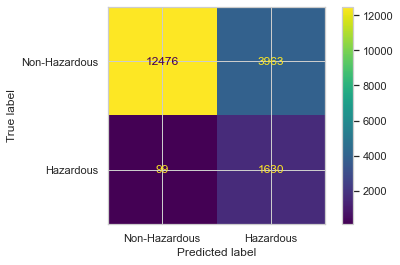

In [14]:
# Plot confusion matrix.
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svml), display_labels=["Non-Hazardous", "Hazardous"])
cmd.plot()

- Even though the scores are not very high, SVM looks beneficial mainly because it yields very low false-negative rates.
- The cost is high false-positives.

In [15]:
# Test K-Nearest Neighbors classifier.
from sklearn.neighbors import KNeighborsClassifier

parameters = {"n_neighbors": list(range(1, 20))}

model_knn = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1).fit(x_train_rs, y_train_rs)

y_pred_knn = model_knn.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_knn, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.957762,0.455131,0.893329,0.706447,0.909928
recall,0.922806,0.613071,0.893329,0.767938,0.893329
f1-score,0.939959,0.522425,0.893329,0.731192,0.900223
support,16439.000000,1729.000000,0.893329,18168.000000,18168.000000


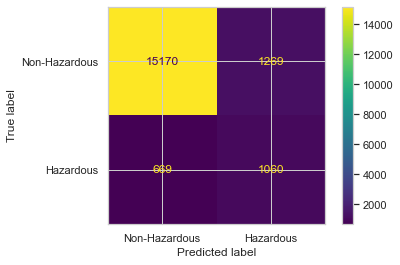

In [16]:
# Plot confusion matrix.
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=["Non-Hazardous", "Hazardous"])
cmd.plot()

- Very high rates of false-negatives makes KNN algorithm ineffective.

In [17]:
# Test Scholastic Gradient Descent classifier.
from sklearn.linear_model import SGDClassifier

parameters = {
    "alpha": [0.0001]
}

model_sgd = GridSearchCV(SGDClassifier(), parameters, n_jobs=-1).fit(x_train_rs, y_train_rs)

y_pred_sgd = model_sgd.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_sgd, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.998413,0.275985,0.752037,0.637199,0.929661
recall,0.727112,0.989011,0.752037,0.858062,0.752037
f1-score,0.841435,0.431546,0.752037,0.636490,0.802427
support,16439.000000,1729.000000,0.752037,18168.000000,18168.000000


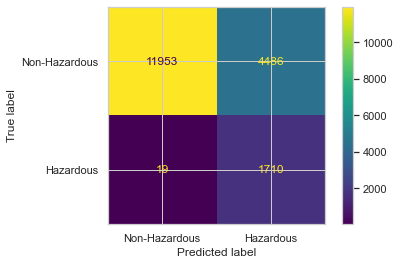

In [18]:
# Plot confusion matrix.
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sgd), display_labels=["Non-Hazardous", "Hazardous"])
cmd.plot()

- Even lower false-negatives than Linear Support Vector machine.
- False positives increases too. 

In [19]:
# Test Random Forest Classifier.
from sklearn.ensemble import RandomForestClassifier

parameters = {
    "max_features": ["sqrt", "log2"]
}

model_rfc = GridSearchCV(RandomForestClassifier(n_estimators=200, n_jobs=-1), parameters, n_jobs=-1).fit(x_train_rs, y_train_rs)

y_pred_rfc = model_rfc.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_rfc, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.972975,0.646647,0.937087,0.809811,0.941919
recall,0.957053,0.747253,0.937087,0.852153,0.937087
f1-score,0.964948,0.693319,0.937087,0.829134,0.939098
support,16439.000000,1729.000000,0.937087,18168.000000,18168.000000


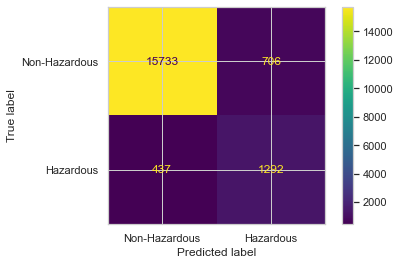

In [37]:
# Plot confusion matrix.
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rfc), display_labels=["Non-Hazardous", "Hazardous"])
cmd.plot()

- Verry accurate model.
- False negatives are highed than KDD and SVM.

## 5- Comparison
We will compare our models in this section. Scores, confusion matrices and AUC-ROC curves will be used.

In [21]:
# Get scores for each model.
linsvc_score = precision_recall_fscore_support(y_test, y_pred_svml)
knn_score = precision_recall_fscore_support(y_test, y_pred_knn)
sgd_score = precision_recall_fscore_support(y_test, y_pred_sgd)
rfc_score = precision_recall_fscore_support(y_test, y_pred_rfc)

In [22]:
# Print scores for Non-Hazardous predictions in tabular form.
score_data = pd.DataFrame({
    "Scholastic Gradient Descent": [sgd_score[0][0], sgd_score[1][0], sgd_score[2][0], sgd_score[3][0]],
    "Linear-SVM": [linsvc_score[0][0], linsvc_score[1][0], linsvc_score[2][0], linsvc_score[3][0]],
    "K-Nearest Neighbour": [knn_score[0][0], knn_score[1][0], knn_score[2][0], knn_score[3][0]],
    "Random Forest": [rfc_score[0][0], rfc_score[1][0], rfc_score[2][0], rfc_score[3][0]]
}, index=["Precision", "Recall", "F-Score", "Support"]).style.set_caption("Scores for Non-Hazardous Predictions")
score_data

,Scholastic Gradient Descent,Linear-SVM,K-Nearest Neighbour,Random Forest
Precision,0.998413,0.992127,0.957762,0.972975
Recall,0.727112,0.758927,0.922806,0.957053
F-Score,0.841435,0.859999,0.939959,0.964948
Support,16439.000000,16439.000000,16439.000000,16439.000000


In [23]:
# Print scores for Hazardous predictions in tabular form.
score_data = pd.DataFrame({
    "Scholastic Gradient Descent": [sgd_score[0][1], sgd_score[1][1], sgd_score[2][1], sgd_score[3][1]],
    "Linear-SVM": [linsvc_score[0][1], linsvc_score[1][1], linsvc_score[2][1], linsvc_score[3][1]],
    "K-Nearest Neighbour": [knn_score[0][1], knn_score[1][1], knn_score[2][1], knn_score[3][1]],
    "Random Forest": [rfc_score[0][1], rfc_score[1][1], rfc_score[2][1], rfc_score[3][1]]
}, index=["Precision", "Recall", "F-Score", "Support"]).style.set_caption("Scores for Hazardous Predictions")
score_data

,Scholastic Gradient Descent,Linear-SVM,K-Nearest Neighbour,Random Forest
Precision,0.275985,0.291436,0.455131,0.646647
Recall,0.989011,0.942741,0.613071,0.747253
F-Score,0.431546,0.445234,0.522425,0.693319
Support,1729.000000,1729.000000,1729.000000,1729.000000


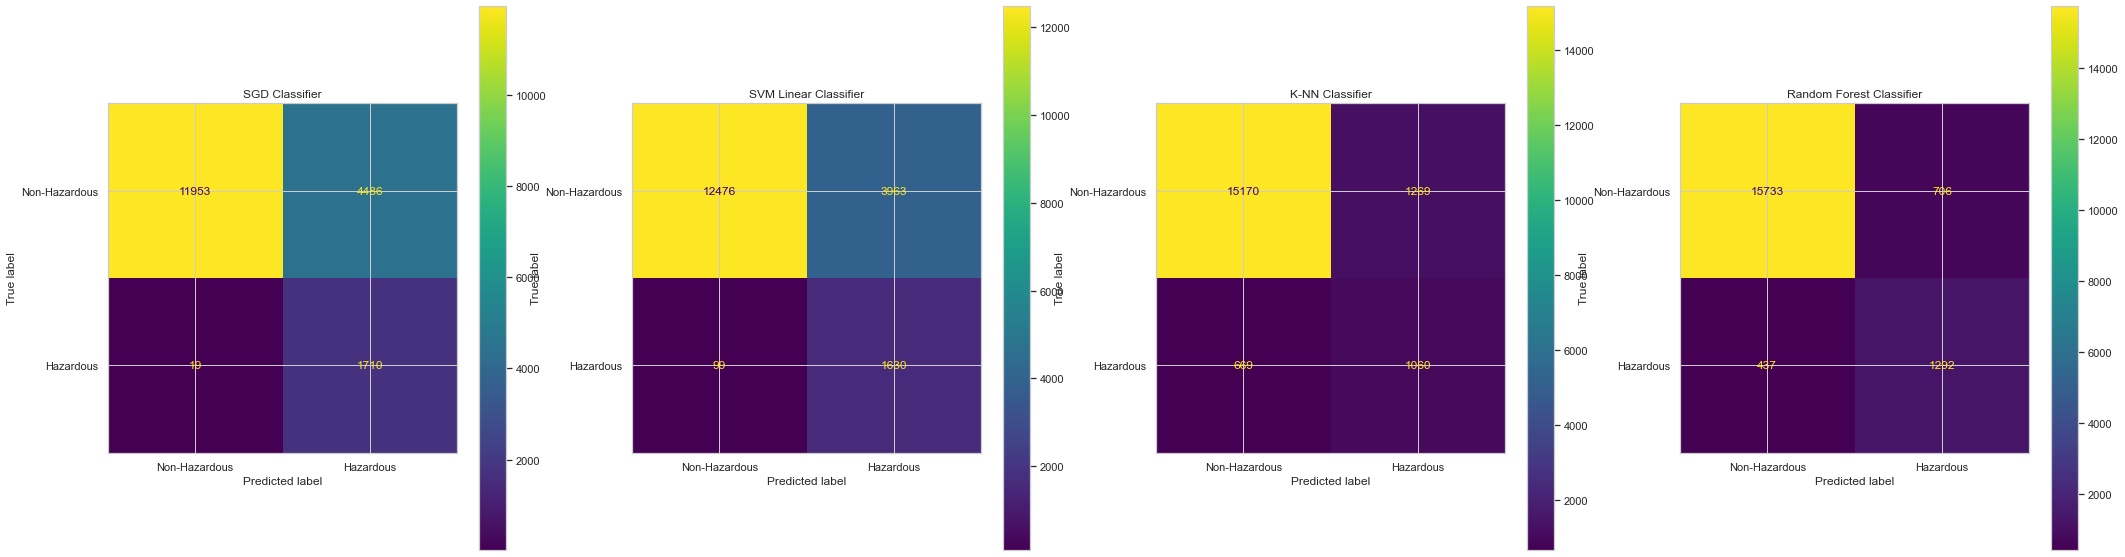

In [90]:
# Plot all confusion matrices.
fig, axs = plt.subplots(1, 4)
fig.set_size_inches(36, 10)


cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sgd), display_labels=["Non-Hazardous", "Hazardous"])
axs[0].title.set_text("SGD Classifier")
cmd.plot(ax=axs[0])

cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svml), display_labels=["Non-Hazardous", "Hazardous"])
axs[1].title.set_text("SVM Linear Classifier")
cmd.plot(ax=axs[1])

cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=["Non-Hazardous", "Hazardous"])
axs[2].title.set_text("K-NN Classifier")
cmd.plot(ax=axs[2])

cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rfc), display_labels=["Non-Hazardous", "Hazardous"])
axs[3].title.set_text("Random Forest Classifier")
cmd.plot(ax=axs[3])

plt.show()

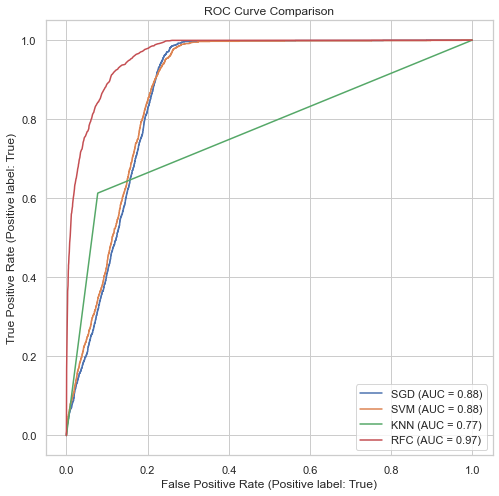

In [89]:
# Plot all ROC curves.
fig, axs = plt.subplots()

fig.set_size_inches(8, 8)
axs.title.set_text("ROC Curve Comparison")

RocCurveDisplay.from_estimator(model_sgd, x_test, y_test, ax=axs, name="SGD")
RocCurveDisplay.from_estimator(model_svml, x_test, y_test, ax=axs, name="SVM")
RocCurveDisplay.from_estimator(model_knn, x_test, y_test, ax=axs, name="KNN")
RocCurveDisplay.from_estimator(model_rfc, x_test, y_test, ax=axs, name="RFC")

plt.show()

## 6- Conclusion:

In this section, we will conclude our observations.

KNN model has a very high false-negative rate, which makes it unusable. SGD and SVM models have very similar outputs, but SGD is slightly better in terms of recall. SGD is the way to go between these 2 options. RFC has higher precision and F1 score then any other.

Depending on the situation, both ***Random Forest Classifier*** Model and ***Scholastic Gradient Descent*** Model can be used.